# Setup

In [3]:
!pip install biopython

In [4]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive')


Mounted at /content/drive


# Smith-Waterman Algorithm

In [5]:
def smith_waterman(seq1, seq2):
    match_score = 1
    mismatch_penalty = -1
    gap_penalty = -2
    m, n = len(seq1), len(seq2)
    score = [[0 for _ in range(n + 1)] for _ in range(m + 1)]

    # Track the max score and its position(s)
    max_score = 0
    max_positions = []

    # Fill the scoring matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_penalty)
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            score[i][j] = max(0, match, delete, insert)
            if score[i][j] > max_score:
                max_score = score[i][j]
                max_positions = [(i, j)]
            elif score[i][j] == max_score:
                max_positions.append((i, j))

    # Traceback to collect up to 10 alignments
    MAX_ALIGNMENTS = 10
    results = set()

    def traceback(i, j, aligned1="", aligned2=""):
        if len(results) >= MAX_ALIGNMENTS or score[i][j] == 0:
            results.add((aligned1[::-1], aligned2[::-1]))
            return
        if i > 0 and j > 0:
            diag = score[i - 1][j - 1]
            if score[i][j] == diag + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_penalty):
                traceback(i - 1, j - 1, aligned1 + seq1[i - 1], aligned2 + seq2[j - 1])
        if i > 0 and score[i][j] == score[i - 1][j] + gap_penalty:
            traceback(i - 1, j, aligned1 + seq1[i - 1], aligned2 + "-")
        if j > 0 and score[i][j] == score[i][j - 1] + gap_penalty:
            traceback(i, j - 1, aligned1 + "-", aligned2 + seq2[j - 1])

    for i, j in max_positions:
        traceback(i, j)

    return max_score, list(results)

In [6]:
def smith_waterman_score(seq1, seq2):
    match_score = 1
    mismatch_penalty = -1
    gap_penalty = -2
    m, n = len(seq1), len(seq2)
    score = [[0 for _ in range(n + 1)] for _ in range(m + 1)]

    max_score = 0

    # Fill the scoring matrix and track max score
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_penalty)
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            score[i][j] = max(0, match, delete, insert)
            max_score = max(max_score, score[i][j])

    return max_score


# importing and reading fastq

In [7]:
import gzip
from Bio import SeqIO

fastq_gz_path = "/content/drive/My Drive/Clustering Through Alignment/zipped_rna_seq/GLDS-255_rna_seq_GSM3932708_trimmed.fastq.gz"


In [8]:
reads = []
with gzip.open(fastq_gz_path, "rt") as handle:  # "rt" = read text mode
    for record in SeqIO.parse(handle, "fastq"):
        reads.append(str(record.seq))

In [9]:
# Select every 10,001st read
reduced_reads = reads[::10001]
len(reduced_reads)

2036

# creating a similarity matrix using the Smith-Waterman algorithm

In [10]:
num_reads = len(reduced_reads)
similarity_matrix = np.zeros((num_reads, num_reads))

In [11]:
# Fill similarity matrix
for i in range(num_reads):
    for j in range(i + 1, num_reads):
        score = smith_waterman_score(reduced_reads[i], reduced_reads[j])
        similarity_matrix[i][j] = similarity_matrix[j][i] = score

# Saving the similarity matrix and accosiated reads as a csv so we don't have to do it again later

In [12]:
write_path = "/content/drive/My Drive/Clustering Through Alignment/Local_similarity_matrix.csv"

In [13]:
write_path2 = "/content/drive/My Drive/Clustering Through Alignment/Local_reduced_reads.csv"

In [14]:
from posix import write
np.savetxt(write_path, similarity_matrix, delimiter=",")

In [15]:
np.savetxt(write_path2, reduced_reads, delimiter=",", fmt="%s")

# Reading the csv and reads into colab

In [16]:
Read_path = "/content/drive/My Drive/Clustering Through Alignment/Local_similarity_matrix.csv"

In [17]:
Read_path2 = "/content/drive/My Drive/Clustering Through Alignment/Local_reduced_reads.csv"

In [18]:
similarity_matrix = np.loadtxt(Read_path, delimiter=",")

In [19]:
reduced_reads = np.loadtxt(Read_path2, delimiter=",", dtype=str)

# Clustering with a threshold of 350

In [20]:
# Convert to distance matrix: higher score = smaller distance
max_score = np.max(similarity_matrix)
distance_matrix = max_score - similarity_matrix

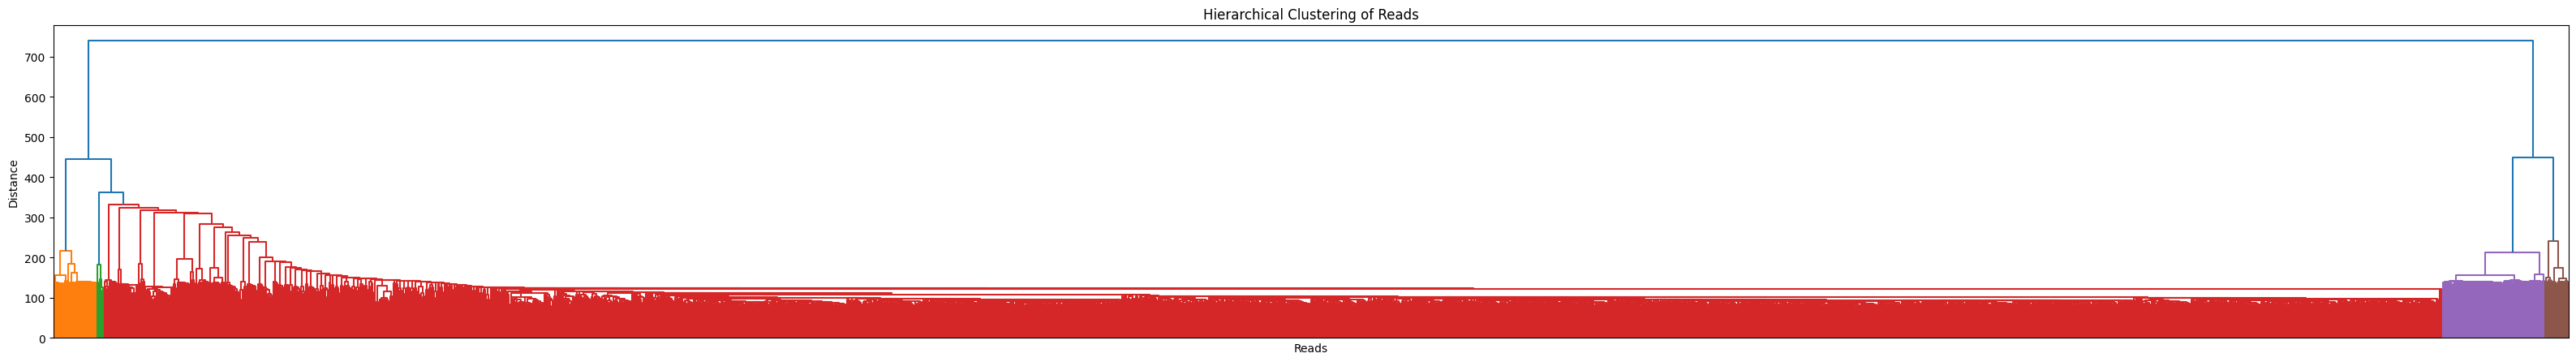

In [21]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform clustering
linked = linkage(distance_matrix, 'average')

plt.figure(figsize=(40, 5))
dendrogram(
    linked,
    no_labels=True,
    color_threshold=350,
)
plt.xlabel("Reads")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering of Reads")
plt.show()


In [22]:
from scipy.cluster.hierarchy import fcluster

clusters = fcluster(linked, t=350, criterion='distance')
print("Cluster assignments:", clusters)

Cluster assignments: [3 3 3 ... 3 3 3]


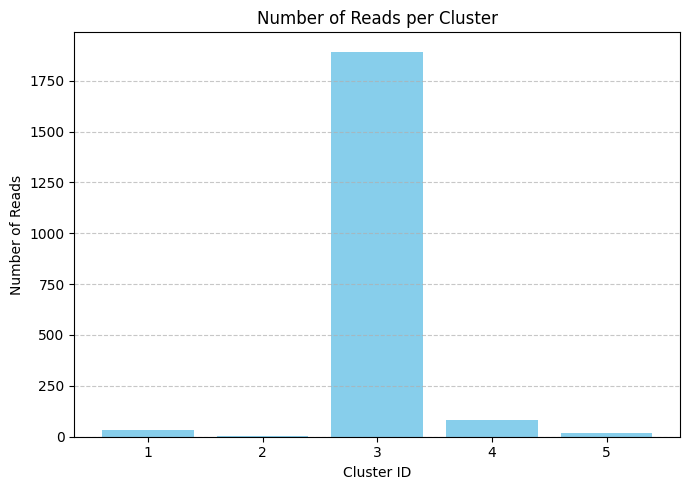

In [23]:
from collections import Counter

# Count number of reads per cluster
cluster_counts = Counter(clusters)

# Sort clusters for cleaner plot
sorted_clusters = sorted(cluster_counts.items())
labels, counts = zip(*sorted_clusters)

# Plot
plt.figure(figsize=(7, 5))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Reads")
plt.title("Number of Reads per Cluster")
plt.xticks(labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The amount of clusters is far too small to the actual data

The amount of reads in each cluster is far too large to have clusters actually have grouped reads of similar genes.

# Clustering with a threshold of 100

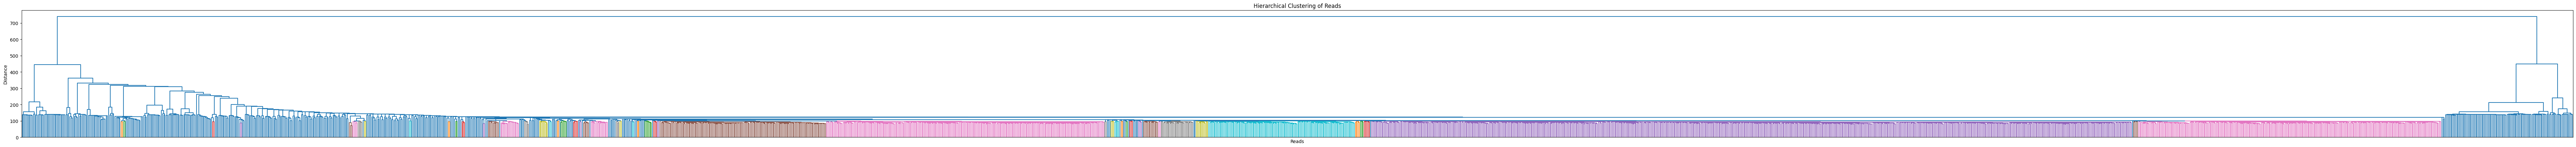

In [24]:
# Perform clustering
linked = linkage(distance_matrix, 'average')

plt.figure(figsize=(100, 5))
dendrogram(
    linked,
    no_labels=True,
    color_threshold=100,
)
plt.xlabel("Reads")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering of Reads")
plt.show()


In [25]:
clusters = fcluster(linked, t=100, criterion='distance')
print("Cluster assignments:", clusters)

Cluster assignments: [425 433 400 ... 430 400 171]


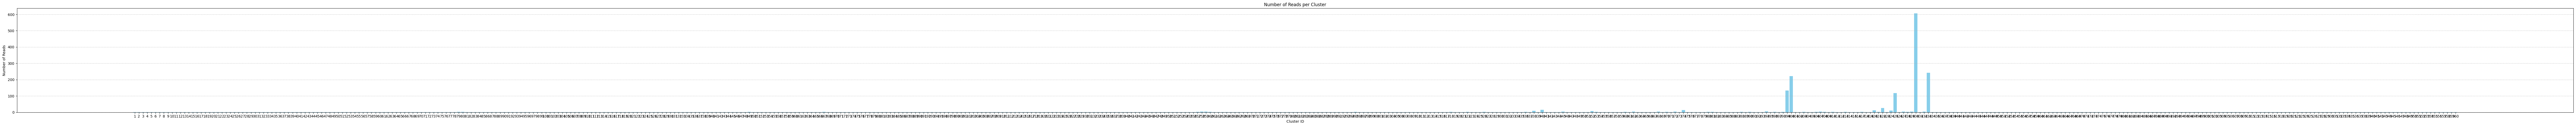

In [26]:
# Count number of reads per cluster
cluster_counts = Counter(clusters)

# Sort clusters for cleaner plot
sorted_clusters = sorted(cluster_counts.items())
labels, counts = zip(*sorted_clusters)

# Plot
plt.figure(figsize=(100, 5))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Reads")
plt.title("Number of Reads per Cluster")
plt.xticks(labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Blasting a subset of the clustered reads to check if the reads in the cluster are similar or not

In [27]:
biggest_cluster_id, biggest_cluster_count = cluster_counts.most_common(1)[0]

print(f"Biggest cluster: {biggest_cluster_id} with {biggest_cluster_count} reads")

Biggest cluster: 430 with 607 reads


In [28]:
# Find indices of reads belonging to cluster 430
cluster_430_indices = np.where(clusters == 430)[0]

# Extract the sequences
cluster_430_reads = [reduced_reads[i] for i in cluster_430_indices]

print(f"Number of reads in cluster 430: {len(cluster_430_reads)}")
for read in cluster_430_reads[:5]:
    print(read)


Number of reads in cluster 430: 607
GGTGAAGGTGTAAACTTGCAGGCTGCATGACCCTTGTTGGGTCAGCTTCTCACCTCTGCCCTCATCATAGCATGAAAGAAGGGATATGTAATATATAAAC
CCGGTGATGATCTTCTTCATGGGCACAATGTATCTCCTTCGAGGGGCTCTCCACAACGGTCGGGCACAAGTGATACGAGGA
GAATAAATTTTATGTATGTGAATACATTGTGGCTCTCTTCAGACACACTAGACAGGGCATCGGATCCCATTACAGGGAATTGAACTCAGGACCTCTGGA
CCACAATGAAACTAGTCTGGAAAAAAAAACTTGCTTTTTGTTGTAGTTACCACTTAACCCTGTAGTTTAACAAGGAATGTCTGTGCCGATAAACCAATTC
CAGCAACACACAAGGCTGCTTGTAAGGGTGAAAGGTTGAGTCAGGCTAACTGAGACAATGAATCTCTTCCCCTCCAGCTGAAGACTTGAGCGCCCTGGCC


In [29]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
import time
import warnings
from Bio import BiopythonWarning
import concurrent.futures

In [30]:
import random

# Randomly select 50 reads
sampled_reads = random.sample(cluster_430_reads, 50)

In [ ]:
blast_results = []

def blast_single_read(read):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", BiopythonWarning)
        result_handle = NCBIWWW.qblast("blastn", "nt", read, hitlist_size=1)
        blast_record = NCBIXML.read(result_handle)

    if blast_record.alignments:
        alignment = blast_record.alignments[0]
        hit_def = alignment.hit_def
        e_value = alignment.hsps[0].expect
        return (read, hit_def, e_value)
    else:
        return (read, "No hit found", None)

for idx, read in enumerate(sampled_reads):
    print(f"BLASTing read {idx+1}/{len(sampled_reads)}...")

    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(blast_single_read, read)
        try:
            result = future.result(timeout=600)  # 600 seconds = 10 minutes
            blast_results.append(result)
        except concurrent.futures.TimeoutError:
            print(f"Skipping read {idx+1} due to timeout (>10 minutes)")
            continue
        except Exception as e:
            print(f"Skipping read {idx+1} due to error: {e}")
            continue

    time.sleep(5)


BLASTing read 1/50...
BLASTing read 2/50...
BLASTing read 3/50...
BLASTing read 4/50...
BLASTing read 5/50...
BLASTing read 6/50...
BLASTing read 7/50...
BLASTing read 8/50...
BLASTing read 9/50...
BLASTing read 10/50...
BLASTing read 11/50...
BLASTing read 12/50...
BLASTing read 13/50...
BLASTing read 14/50...
BLASTing read 15/50...
BLASTing read 16/50...
BLASTing read 17/50...
BLASTing read 18/50...
BLASTing read 19/50...
BLASTing read 20/50...
BLASTing read 21/50...
BLASTing read 22/50...


In [ ]:
for read, hit, e_value in blast_results:
    print(f"Top hit: {hit} | e-value: {e_value}")

Even with the much smaller threshold of 100, the clusters do not accuratly separate groups of similar genes into clusters.